<a href="https://colab.research.google.com/github/hsalce2005/data_club/blob/main/Data_Club_Workshop_3_NLP_(10_23_24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Club - Natural Language Processing Song Lyrics

In [ ]:
import nltk
import os
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
print(nltk.__version__)

3.8.1


In [ ]:
stops = set(stopwords.words('english'))
remove = {'pre', 'refrain', 'chorus'}
stops = stops.union(remove)

In [ ]:
# pre-process data
artist_data = dict()
artists = pd.read_csv('top_10k_artists.csv').artist.tolist()

In [ ]:
def process_file(file):
  # get rid of csv at end of file
  name = os.path.basename(file)[:-4]

  df = pd.read_csv(file)
  df = df.dropna(subset=['Album', 'Lyric'])

  # getting rid of deluxe/live albums (~means not true, only gets rid of things with 'Tour', 'Edition', etc.)
  df = df[(~df.Title.str.contains('Tour')) & (~df.Title.str.contains('Edition|Demo')) & (~df.Album.str.contains(r"[\(\[]"))]

  # group by album name as opposed to individual songs
  grouped = df.groupby('Album')['Lyric'].agg(' '.join).to_dict()
  artist_data[name] = grouped
  print(f'Read song lyrics for: {name}')

In [ ]:
# remove predefined stopwords
def remove_stops(lyrics):
  return [word for word in lyrics if word not in stops and "'" not in word]

# remove artist name from lyrics
def remove_artist(lyrics):
  for artist in artists:
    if lyrics.startswith(artist):
      lyrics = lyrics.replace(artist, ' ', 1)
    # ex. lyrics Rihanna lyrics -> lyrics lyrics
    lyrics = lyrics.replace(' '+artist+' ', ' ')

  lyric_list = remove_stops(lyrics.strip().split())

  return lyric_list

In [ ]:
sia = SentimentIntensityAnalyzer()

# iterate through files and do what functions above did and then store in intialized dict
for artist in ['ArianaGrande', 'Rihanna', 'TaylorSwift']:
  process_file(artist+'.csv')

  for album in artist_data[artist].keys():
    words = remove_artist(artist_data[artist][album])
    # keep as a string to analyze as a sentence as opposed to words in a list
    words_string = ' '.join(words)

    scores = sia.polarity_scores(words_string)

    pos = scores['pos']
    neg = scores['neg']
    compound = scores['compound']
    # counter takes in a list and counts occurance of each word
    album_data = {
        'wordcount': Counter(words),
        'sentiment_score': compound,
        'pos': pos,
        'neg': neg,
        'words': words
    }

    artist_data[artist][album] = album_data

Read song lyrics for: ArianaGrande
Read song lyrics for: Rihanna
Read song lyrics for: TaylorSwift


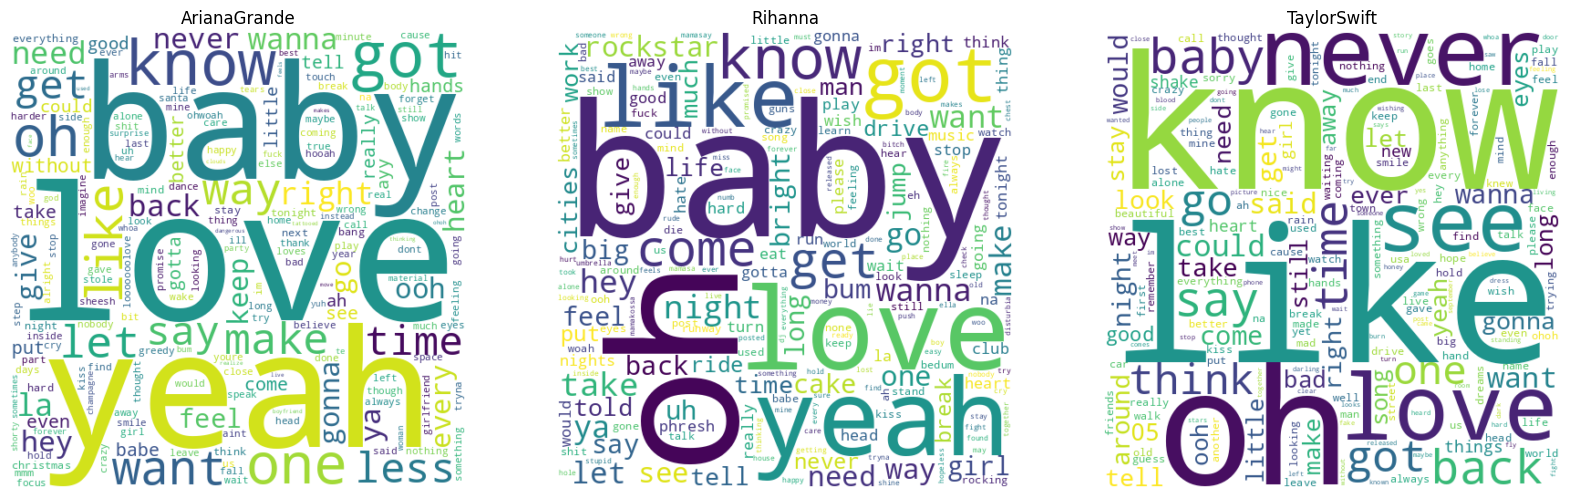

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 16))

# counter
i = 0
for artist in ['ArianaGrande', 'Rihanna', 'TaylorSwift']:
  total_count = Counter()
  for album in artist_data[artist].keys():
    # combine counts ex. 3 of word 'apple' in one song, 2 in another combines into 5
    total_count.update(artist_data[artist][album]['wordcount'])

  wordcloud = WordCloud(background_color='white', width=500, height=500).generate_from_frequencies(total_count)
  ax[i].imshow(wordcloud, interpolation='bilinear')
  ax[i].set_title(artist)
  ax[i].axis('off')
  i += 1

plt.savefig('wordcloud.png')

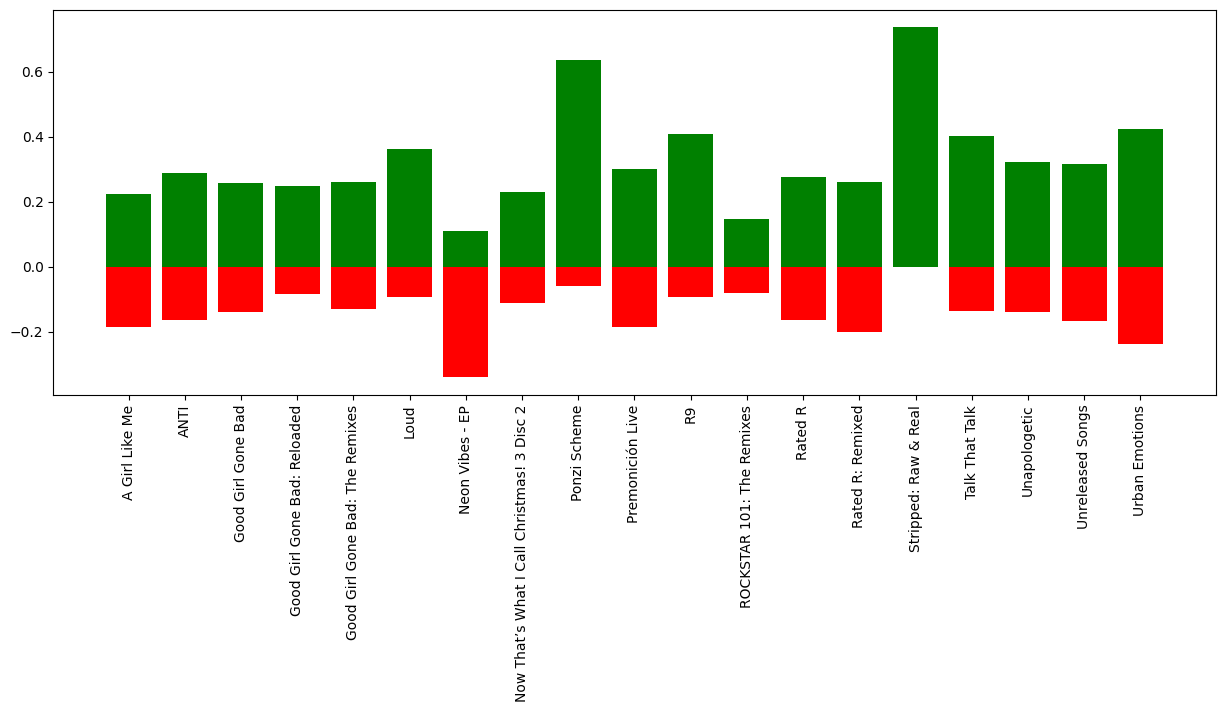

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

artist = artist_data['Rihanna']

for album in artist.keys():
  data = artist[album]
  ax.bar(album, data['pos'], color='green')
  ax.bar(album, -data['neg'], color='red')
  ax.tick_params(axis='x', labelrotation=90)